## 03 - Natural Gas Forecasting 

Tras el análisis exploratorio, hemos identificado que la serie de generación de energía a partir de **Gas Natural** presenta una tendencia creciente y una clara estacionalidad anual. Por ello, resulta interesante realizar una predicción de los próximos 3 años (36 meses) para esta fuente.

Con este objetivo, aplicaremos dos enfoques diferentes:

- **SARIMA (Seasonal ARIMA):** un modelo clásico de series temporales que requiere que la serie sea estacionaria. Aplicaremos las transformaciones necesarias y ajustaremos los parámetros del modelo.

- **Prophet (modelo de Meta):** una alternativa moderna que permite modelar directamente tendencias y estacionalidades sin necesidad de convertir la serie en estacionaria. Es especialmente útil para series con cambios estructurales o festivos.

Con estos modelos, compararemos los resultados y visualizaremos la evolución esperada de la generación de energía por Gas Natural hasta 2027.

---

## **Modelo SARIMA**

Empezaremos cargando el dataframe y escogiendo natural gas, y haciendo pruebas para comprobar su estacionariedad y tendencia:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../data/cleandf.csv", index_col="DATE", parse_dates=True)
gas = df['Natural Gas']
gas

DATE
2001-01-01    169554652.0
2001-02-01    151867704.0
2001-03-01    177457656.0
2001-04-01    183370982.0
2001-05-01    203736820.0
                 ...     
2024-08-01    812299616.0
2024-09-01    677573758.0
2024-10-01    585390980.0
2024-11-01    548165655.0
2024-12-01    581460048.0
Name: Natural Gas, Length: 288, dtype: float64

Vamso a visualizar la serie para tener una imagen clara:

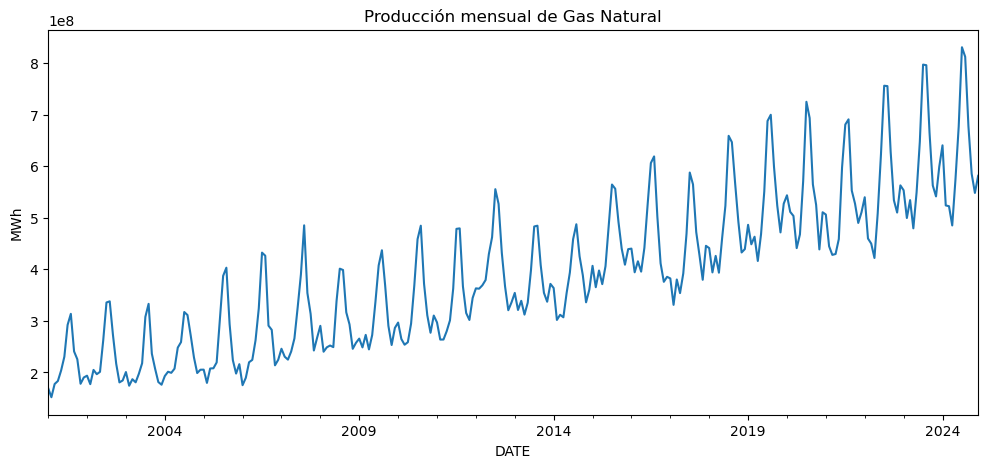

In [4]:
import matplotlib.pyplot as plt

gas.plot(figsize=(12,5), title="Producción mensual de Gas Natural")
plt.ylabel("MWh")
plt.show()

Vamso a descomponerlo para ver su etndencia, estacionariedad y ruido:

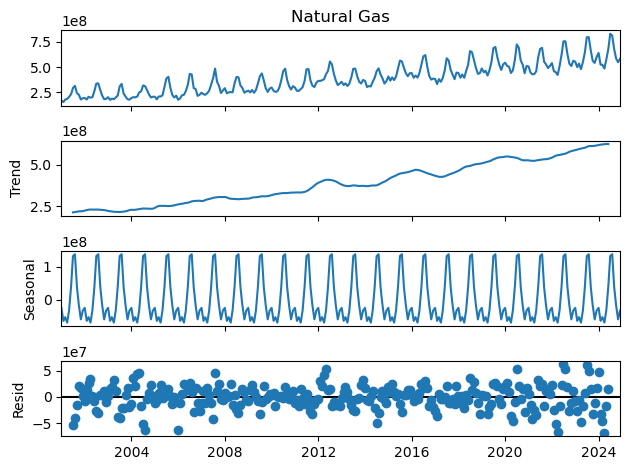

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(gas, model='additive', period=12)
result.plot()
plt.show()

Podemos ver como la tendencia es positiva y hay estacionariedad

Haremos la prueba de Dickey-Fuller para comprobar esta estacionariedad y hacer diferencia si hace falta:

In [6]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(gas)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("La serie es estacionaria" if adf_result[1] < 0.05 else "La serie no es estacionaria")

ADF Statistic: -0.1873464446982009
p-value: 0.9400131762381069
La serie no es estacionaria


Podemos observar como después de aplicar este test, nos indica que la serie no es estacionaria, por lo que deberemos probar a hacer una diferencia y proabr de nuevo:

In [7]:
gas_diff = gas.diff().dropna()
adf_result = adfuller(gas_diff)

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("La serie es estacionaria" if adf_result[1] < 0.05 else "La serie no es estacionaria")

ADF Statistic: -4.408470433258942
p-value: 0.00028675278705056733
La serie es estacionaria


Después de realizar una diferencia, podemos observar como ahora si es estacionaria, además, ya sabemos que el parámetro "d" para el modelo SARIMA será 1

Vamos ahora a realizar el gráfico de autocorrelación y autocorrelación parcial y obtener los parámetros "p" y "q":

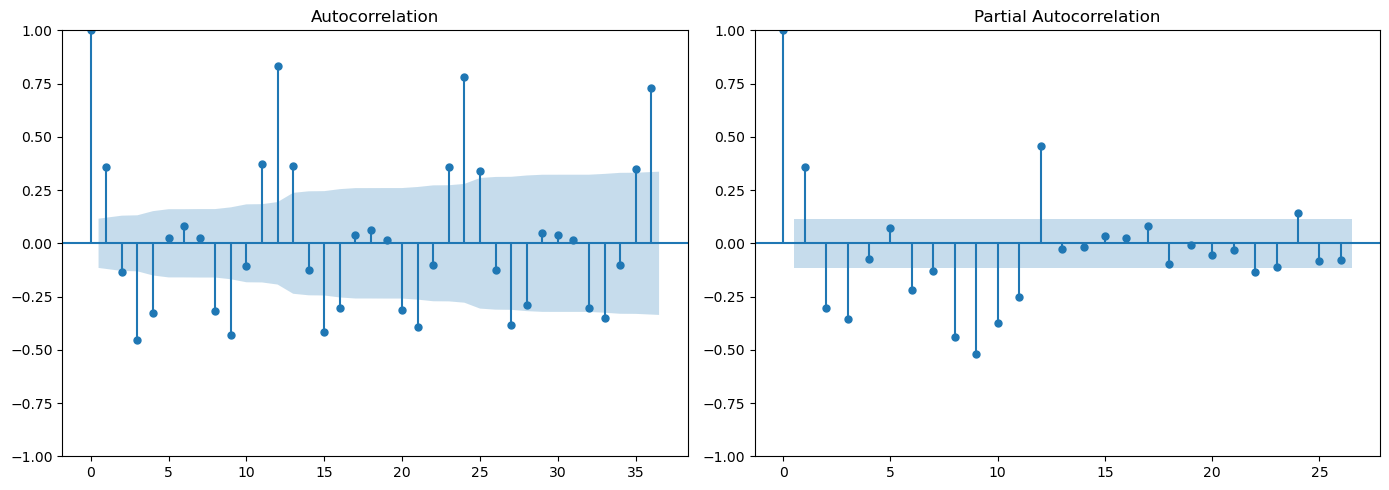

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize = (14, 5))
plot_acf(gas_diff, lags=36, ax = ax[0])
plot_pacf(gas_diff, lags=26, ax = ax[1])
plt.tight_layout()
plt.show()

**ACF:**

Se observa un spike muy fuerte en el lag 1 (por encima del intervalo de confianza).

Ttambién hay otros picos significativos en los lags 11, 24 y 36, lo que puede indicar estacionalidad anual (cada 12 meses), algo típico en series mensuales.

Como solo el primer lag es claramente significativo, probaremos con q = 1, también podríamso probar con q = 2

**PACF:**

El lag 1 también es claramente significativo, podemos probar con p = 1, aunque también se podría probar con p = 3 ya que puede seguir siendo significativo

---

Podemos pasar ya a entrenar el modelo, empezaremos diviendo el conjunto de datos en entrenamiento y prueba:

In [9]:
train_size = int(len(gas) * 0.8)

train, test = gas.iloc[:train_size], gas.iloc[train_size:]

print(f"Tamaño de train: {len(train)}, y tamaño de test: {len(test)}")

train.index = pd.to_datetime(train.index)
train = train.asfreq('MS') 


Tamaño de train: 230, y tamaño de test: 58


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train, 
                       order = (3,1,2), 
                       seasonal_order=(1,1,3,12))

sarima_result = sarima_model.fit()

c:\Users\sergi\anaconda3\envs\prophet_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\sergi\anaconda3\envs\prophet_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\sergi\anaconda3\envs\prophet_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
sarima_forecast = sarima_result.get_forecast(steps=len(test))
predictions = pd.DataFrame({
    "Real generation": test,
    "Pred_SARIMA": sarima_forecast.predicted_mean
})
predictions.head()

,Real generation,Pred_SARIMA
2020-03-01,503581637.0,5.304387e+08
2020-04-01,441166139.0,4.928836e+08
2020-05-01,467734017.0,5.399624e+08
2020-06-01,571289988.0,6.120045e+08
2020-07-01,724992392.0,7.276182e+08


Podemos evaluar los resultados con MAE y RSME

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, predictions["Pred_SARIMA"])
rmse = np.sqrt(mean_squared_error(test, predictions["Pred_SARIMA"]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 40143238.08
RMSE: 47215147.84


Esto valores puden parecer muy grandes, pero en el caso de la generación, maneja cifras gigantes, lo veremos mejor como porcentaje:

In [13]:
# Porcentajes respecto al valor medio
mae_pct_mean = (mae / test.mean()) * 100
rmse_pct_mean = (rmse / test.mean()) * 100

# Porcentajes respecto al valor máximo
mae_pct_max = (mae / test.max()) * 100
rmse_pct_max = (rmse / test.max()) * 100

print(f"MAE (% del valor medio): {mae_pct_mean:.2f}%")
print(f"RMSE (% del valor medio): {rmse_pct_mean:.2f}%")
print(f"MAE (% del valor máximo): {mae_pct_max:.2f}%")
print(f"RMSE (% del valor máximo): {rmse_pct_max:.2f}%")


MAE (% del valor medio): 7.01%
RMSE (% del valor medio): 8.25%
MAE (% del valor máximo): 4.83%
RMSE (% del valor máximo): 5.68%


**Respecto al valor medio de la serie real:**

- MAE (%): 7% → En promedio, el modelo se desvía un 7% del valor medio real.

- RMSE (%): 8.24% → El error cuadrático medio es del 8.24% del valor medio real.

**Respecto al valor máximo de la serie:**

- MAE (%): 4.82%

- RMSE (%): 5.67%

Estos son resultados bastante buenos

Podemos también visualizar la predicción:

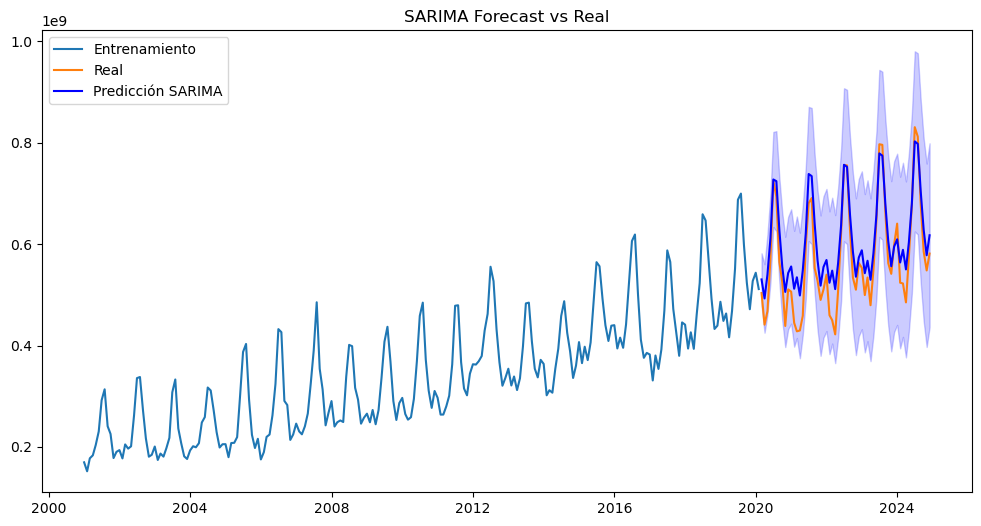

In [14]:
import matplotlib.pyplot as plt

conf_int = sarima_forecast.conf_int()

predictions["Lower CI"] = conf_int.iloc[:, 0].values
predictions["Upper CI"] = conf_int.iloc[:, 1].values

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Entrenamiento")
plt.plot(test.index, test, label="Real")
plt.plot(predictions.index, predictions["Pred_SARIMA"], label="Predicción SARIMA", color="blue")
plt.fill_between(predictions.index, predictions["Lower CI"], predictions["Upper CI"], color='blue', alpha=0.2)
plt.legend()
plt.title("SARIMA Forecast vs Real")
plt.show()


Podemos observar como las predicciones se acercan mucho al valor real, con algo menos de volatilidad

Listo, ahora, para hacer predicciones a futuro, entrenaremos el modelo con todos los datos y haremos la prediccón a 3 años, 36 meses:

c:\Users\sergi\anaconda3\envs\prophet_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\anaconda3\envs\prophet_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


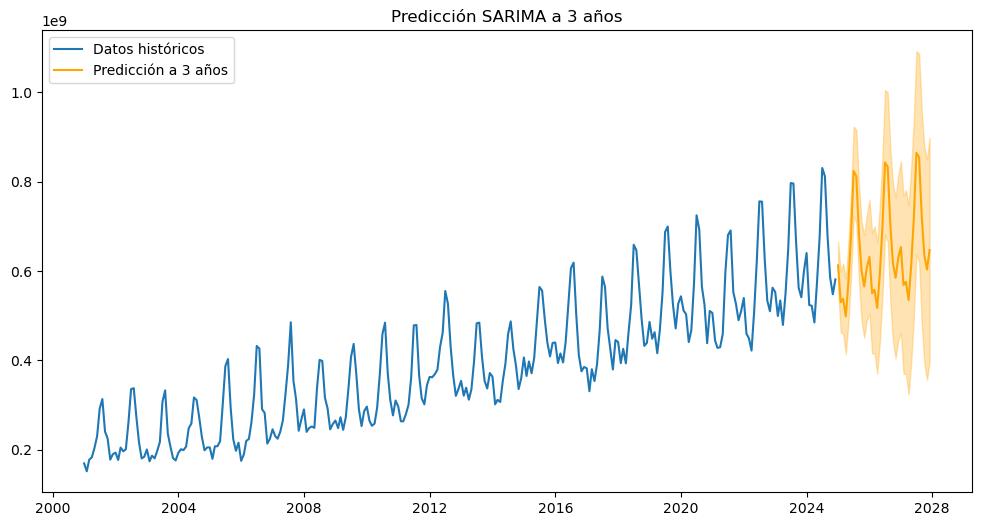

In [14]:
sarima_full_model = SARIMAX(gas,  
                            order=(3,1,2), 
                            seasonal_order=(1,1,3,12))
sarima_full_result = sarima_full_model.fit()

forecast_3years = sarima_full_result.get_forecast(steps=36)
predicted_mean = forecast_3years.predicted_mean
conf_int = forecast_3years.conf_int()

# Crear índice para las fechas futuras
last_date = gas.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(), periods=36, freq='MS')

plt.figure(figsize=(12,6))
plt.plot(gas.index, gas, label='Datos históricos')
plt.plot(future_dates, predicted_mean, label='Predicción a 3 años', color='orange')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.title('Predicción SARIMA a 3 años')
plt.legend()
plt.show()

¡Listo! Ya tenemos nuestras predicciones.

Podemos guardar el modelo para hacer predicciones futuras.

In [15]:
import joblib

joblib.dump(sarima_full_result, "../models/sarima_model.pkl")

['../models/sarima_model.pkl']

---------------

## **Modelo Prophet**

Este modelo creado por Meta es útil para pronósticos univariados con tendencia y estacionaldiad, por lo que encaja perfectamente con la serie de Natural gas, por lo que lo probaremos:

In [16]:
from prophet import Prophet

c:\Users\sergi\anaconda3\envs\prophet_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


En primer lugar, prophet necesita dos columnas con los nombres exactos:"ds" para la fecha y "y" para el valor, por lo que cambiaremos esto:

In [17]:
df_prophet = gas.reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet

,ds,y
0,2001-01-01,169554652.0
1,2001-02-01,151867704.0
2,2001-03-01,177457656.0
3,2001-04-01,183370982.0
4,2001-05-01,203736820.0
...,...,...
283,2024-08-01,812299616.0
284,2024-09-01,677573758.0
285,2024-10-01,585390980.0
286,2024-11-01,548165655.0


Creamos y ajustamos el modelo, predecimos un año

In [26]:
m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=365)
future

11:55:04 - cmdstanpy - INFO - Chain [1] start processing
11:55:04 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2001-01-01
1,2001-02-01
2,2001-03-01
3,2001-04-01
4,2001-05-01
...,...
648,2025-11-27
649,2025-11-28
650,2025-11-29
651,2025-11-30


In [29]:
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,2.051791e+08,1.283876e+08,2.048594e+08,2.051791e+08,2.051791e+08,-3.821779e+07,-3.821779e+07,-3.821779e+07,-3.821779e+07,-3.821779e+07,-3.821779e+07,0.0,0.0,0.0,1.669613e+08
1,2001-02-01,2.062570e+08,8.830029e+07,1.675781e+08,2.062570e+08,2.062570e+08,-7.814223e+07,-7.814223e+07,-7.814223e+07,-7.814223e+07,-7.814223e+07,-7.814223e+07,0.0,0.0,0.0,1.281147e+08
2,2001-03-01,2.072306e+08,1.176731e+08,1.929792e+08,2.072306e+08,2.072306e+08,-5.317317e+07,-5.317317e+07,-5.317317e+07,-5.317317e+07,-5.317317e+07,-5.317317e+07,0.0,0.0,0.0,1.540574e+08
3,2001-04-01,2.083085e+08,1.010573e+08,1.749877e+08,2.083085e+08,2.083085e+08,-7.080633e+07,-7.080633e+07,-7.080633e+07,-7.080633e+07,-7.080633e+07,-7.080633e+07,0.0,0.0,0.0,1.375022e+08
4,2001-05-01,2.093517e+08,1.362014e+08,2.104767e+08,2.093517e+08,2.093517e+08,-3.613597e+07,-3.613597e+07,-3.613597e+07,-3.613597e+07,-3.613597e+07,-3.613597e+07,0.0,0.0,0.0,1.732157e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,2025-11-27,6.502960e+08,5.676457e+08,6.458733e+08,6.500145e+08,6.505696e+08,-4.267512e+07,-4.267512e+07,-4.267512e+07,-4.267512e+07,-4.267512e+07,-4.267512e+07,0.0,0.0,0.0,6.076209e+08
649,2025-11-28,6.503543e+08,5.675453e+08,6.430326e+08,6.500712e+08,6.506289e+08,-4.530920e+07,-4.530920e+07,-4.530920e+07,-4.530920e+07,-4.530920e+07,-4.530920e+07,0.0,0.0,0.0,6.050451e+08
650,2025-11-29,6.504126e+08,5.678177e+08,6.412234e+08,6.501278e+08,6.506881e+08,-4.560704e+07,-4.560704e+07,-4.560704e+07,-4.560704e+07,-4.560704e+07,-4.560704e+07,0.0,0.0,0.0,6.048055e+08
651,2025-11-30,6.504709e+08,5.723895e+08,6.451669e+08,6.501840e+08,6.507473e+08,-4.342450e+07,-4.342450e+07,-4.342450e+07,-4.342450e+07,-4.342450e+07,-4.342450e+07,0.0,0.0,0.0,6.070464e+08


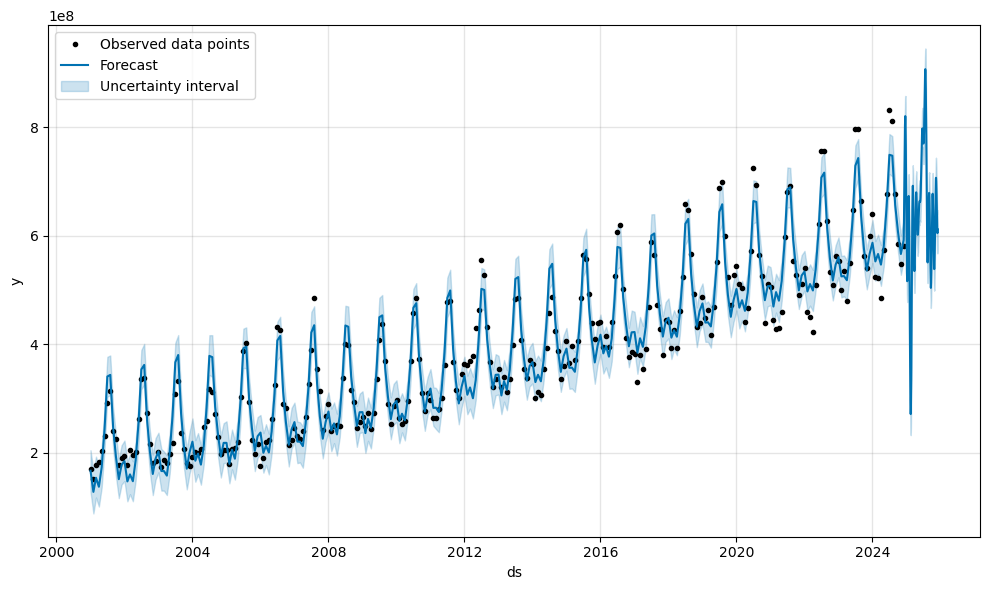

In [30]:
fig1 = m.plot(forecast, include_legend=True)

Podemos ver como el modelo no se ha ajustado nada bien y ha hecho una mala predicción, con alta volatilidad

Probaremos a cambiar el seasonality mode y pondremos intervalo de confianza de 95%, haremos prediccioens a 3 años

12:18:15 - cmdstanpy - INFO - Chain [1] start processing
12:18:15 - cmdstanpy - INFO - Chain [1] done processing


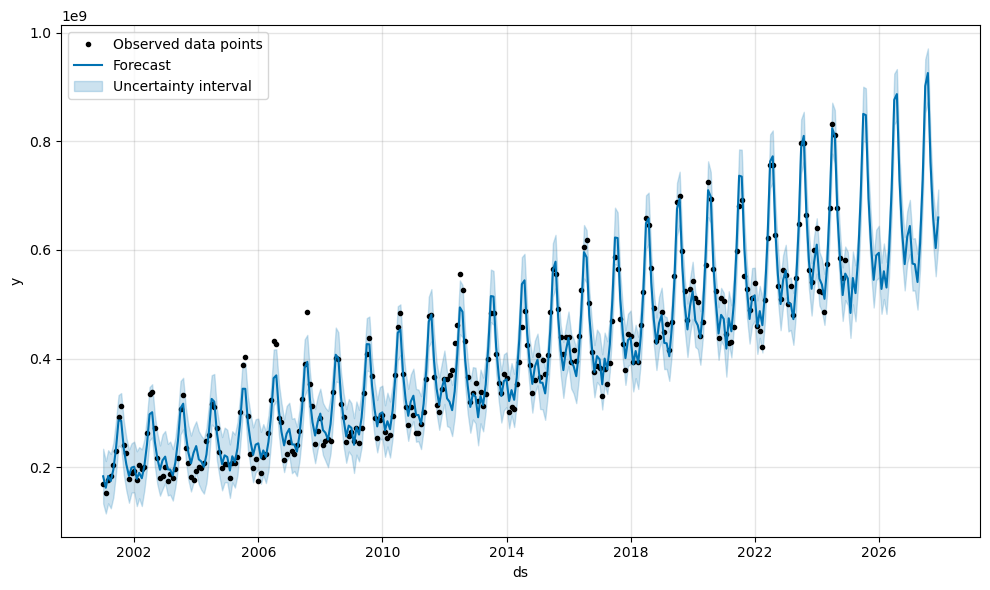

In [ ]:
pmodel = Prophet(interval_width=0.95, yearly_seasonality=True, seasonality_mode='multiplicative')
pmodel.fit(df_prophet)
future = pmodel.make_future_dataframe(36, freq='MS')
forecast = pmodel.predict(future)
fig = pmodel.plot(forecast, include_legend=True)

Listo, podemos ver que el gráfico se ajusta bastante bien.

- MAE del 6.54% respecto al valor medio: El error medio absoluto es solo un 6.54% del promedio histórico de la variable, lo que indica que el modelo tiene un buen nivel de precisión relativa a la media de los datos.

- RMSE del 7.82% respecto al valor medio: La raíz del error cuadrático medio representa menos del 8% del valor promedio, confirmando que el modelo es bastante consistente en sus predicciones.

- MAE del 3.07% respecto al valor máximo: El error medio absoluto es un 3.07% del valor máximo registrado, señalando que en relación con los valores más altos, el modelo realiza predicciones bastante cercanas.

- RMSE del 3.67% respecto al valor máximo: La dispersión típica de los errores es baja en comparación con el máximo histórico, lo que refuerza la robustez del modelo frente a valores extremos.

Guardaremos el modelo para su futuro uso:

In [53]:
joblib.dump(pmodel, "../models/prophet_model.pkl")

['../models/prophet_model.pkl']

Vamso a comparar los resultados de ambos modelos:

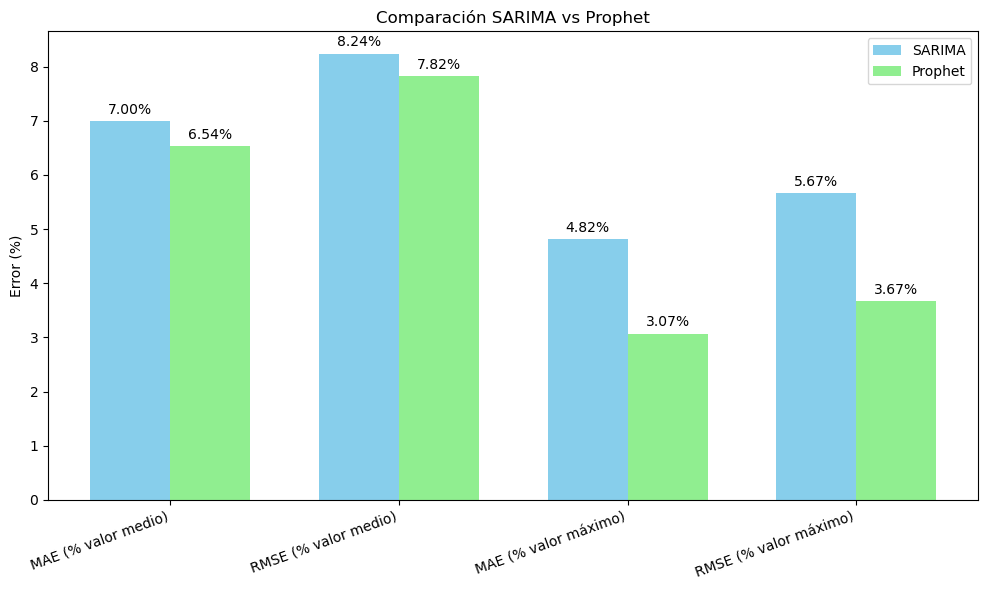

In [22]:
metrics = ['MAE (% valor medio)', 'RMSE (% valor medio)', 
           'MAE (% valor máximo)', 'RMSE (% valor máximo)']

sarima = [7.00, 8.24, 4.82, 5.67]
prophet = [6.54, 7.82, 3.07, 3.67]

x = np.arange(len(metrics))  
width = 0.35  

# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, sarima, width, label='SARIMA', color='skyblue')
bars2 = ax.bar(x + width/2, prophet, width, label='Prophet', color='lightgreen')


ax.set_ylabel('Error (%)')
ax.set_title('Comparación SARIMA vs Prophet')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=20, ha='right')
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

## **Comparación SARIMA vs Prophet**

| Métrica              | SARIMA  | Prophet | Diferencia | Mejora con Prophet |
|----------------------|---------|---------|------------|--------------------|
| MAE (% valor medio)  | 7.00%   | 6.54%   | 0.46%      | 6.57%              |
| RMSE (% valor medio) | 8.24%   | 7.82%   | 0.42%      | 5.10%              |
| MAE (% valor máximo) | 4.82%   | 3.07%   | 1.75%      | 36.31%             |
| RMSE (% valor máximo)| 5.67%   | 3.67%   | 2.00%      | 35.27%             |


## **Conclusiones**

Prophet ha demostrado ser superior a SARIMA en este conjunto de datos específico, con mejoras en todas las métricas evaluadas.

- Mayor precisión general
- Significativamente mejor rendimiento en valores extremos
- Estacionalidad multiplicativa captura mejor los patrones